In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [2]:
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import torchvision
from transformers import ViTMAEForPreTraining
from tqdm import tqdm
import torch.nn as nn
from einops import rearrange
from torch.cuda.amp import autocast, GradScaler

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformation: using 224x224 as model expects
img_size = 224
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load CIFAR-10 and create known/unknown splits
train_dataset_full = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
known_classes = [0, 1, 2, 3, 4]
unknown_classes = [5, 6, 7, 8, 9]

known_idxs = [i for i, (_, label) in enumerate(train_dataset_full) if label in known_classes]
unknown_idxs = [i for i, (_, label) in enumerate(train_dataset_full) if label in unknown_classes]
known_data = Subset(train_dataset_full, known_idxs)
unknown_data = Subset(train_dataset_full, unknown_idxs)

# Reduced batch size (from 8 to 4) to reduce memory consumption
train_loader = DataLoader(known_data, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(unknown_data, batch_size=1, shuffle=False)

# Load the official MAE ViT base model from Hugging Face.
model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base").to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Initialize AMP GradScaler
scaler = GradScaler()
num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for images, _ in progress_bar:
        images = images.to(device)  # [B, 3, 224, 224]
        optimizer.zero_grad()
        
        # Mixed precision forward pass
        with autocast():
            outputs = model(pixel_values=images)
            
            # Use the model's output for reconstruction, checking attribute
            if hasattr(outputs, "reconstruction"):
                reconstructions = outputs.reconstruction
            else:
                reconstructions = outputs.logits
            
            # Rearrange images into patches [B, 196, 768]
            target_patches = rearrange(images, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
            
            loss = loss_fn(reconstructions, target_patches)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}: Average Loss {avg_loss:.4f}")

# Testing on unseen classes:
model.eval()
recon_errors = []
with torch.no_grad():
    for images, _ in tqdm(test_loader, desc="Testing on Unknown Classes"):
        images = images.to(device)
        with autocast():
            outputs = model(pixel_values=images)
            if hasattr(outputs, "reconstruction"):
                reconstructions = outputs.reconstruction
            else:
                reconstructions = outputs.logits
            target_patches = rearrange(images, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
            loss = loss_fn(reconstructions, target_patches)
        
        recon_errors.append(loss.item())

avg_recon_error = sum(recon_errors) / len(recon_errors)
print(f"Average reconstruction error on unseen classes: {avg_recon_error:.4f}")


/home/siddhartha-pittala/miniconda3/envs/gpu-test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified


/tmp/ipykernel_41728/581887860.py:43: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/1:   0%|                                                                                                                                               | 0/6250 [00:00<?, ?it/s]/tmp/ipykernel_41728/581887860.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6250/6250 [16:22<00:00,  6.36it/s, loss=0.0088]


Epoch 1: Average Loss 0.0115


Testing on Unknown Classes:   0%|                                                                                                                             | 0/25000 [00:00<?, ?it/s]/tmp/ipykernel_41728/581887860.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Testing on Unknown Classes: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [06:24<00:00, 65.05it/s]

Average reconstruction error on unseen classes: 0.0129


In [3]:
# Save the model
torch.save(model.state_dict(), 'mae_model_1epoch_.pth')


In [5]:
recon_errors_seen = []

model.eval()
with torch.no_grad():
    for batch in tqdm(train_loader):
        images = batch[0].to(device)  # <-- fixed here

        with torch.autocast('cuda'):
            outputs = model(images)

        reconstructions = outputs.logits
        target_patches = rearrange(images, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
        loss = loss_fn(reconstructions, target_patches)

        recon_errors_seen.append(loss.item())

avg_recon_error_seen = sum(recon_errors_seen) / len(recon_errors_seen)
print(f"Average reconstruction error on SEEN classes: {avg_recon_error_seen:.4f}")


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6250/6250 [02:49<00:00, 36.90it/s]

Average reconstruction error on SEEN classes: 0.0107


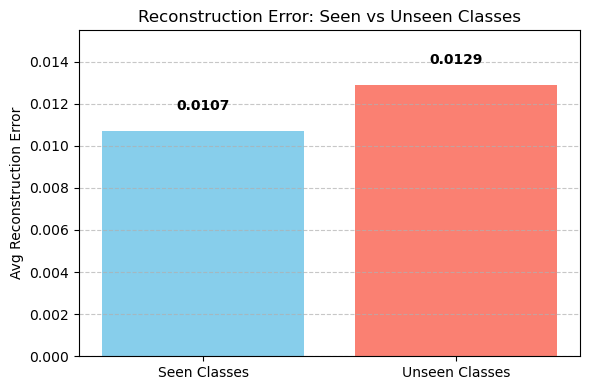

In [7]:
import matplotlib.pyplot as plt

# Assuming these variables exist
seen_error = avg_recon_error_seen
unseen_error = avg_recon_error

# Plotting
labels = ['Seen Classes', 'Unseen Classes']
errors = [seen_error, unseen_error]

plt.figure(figsize=(6, 4))
plt.bar(labels, errors, color=['skyblue', 'salmon'])
plt.ylabel("Avg Reconstruction Error")
plt.title("Reconstruction Error: Seen vs Unseen Classes")
plt.ylim(0, max(errors) * 1.2)
for i, v in enumerate(errors):
    plt.text(i, v + 0.001, f"{v:.4f}", ha='center', fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


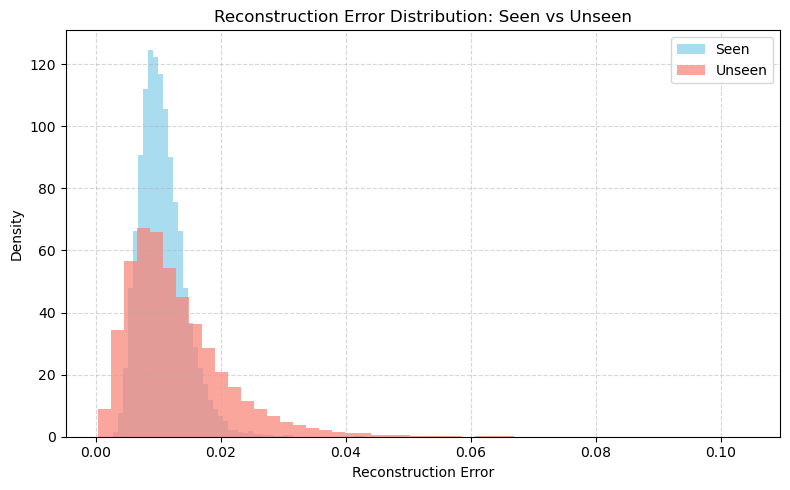

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(recon_errors_seen, bins=50, alpha=0.7, label="Seen", color="skyblue", density=True)
plt.hist(recon_errors, bins=50, alpha=0.7, label="Unseen", color="salmon", density=True)
plt.xlabel("Reconstruction Error")
plt.ylabel("Density")
plt.title("Reconstruction Error Distribution: Seen vs Unseen")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


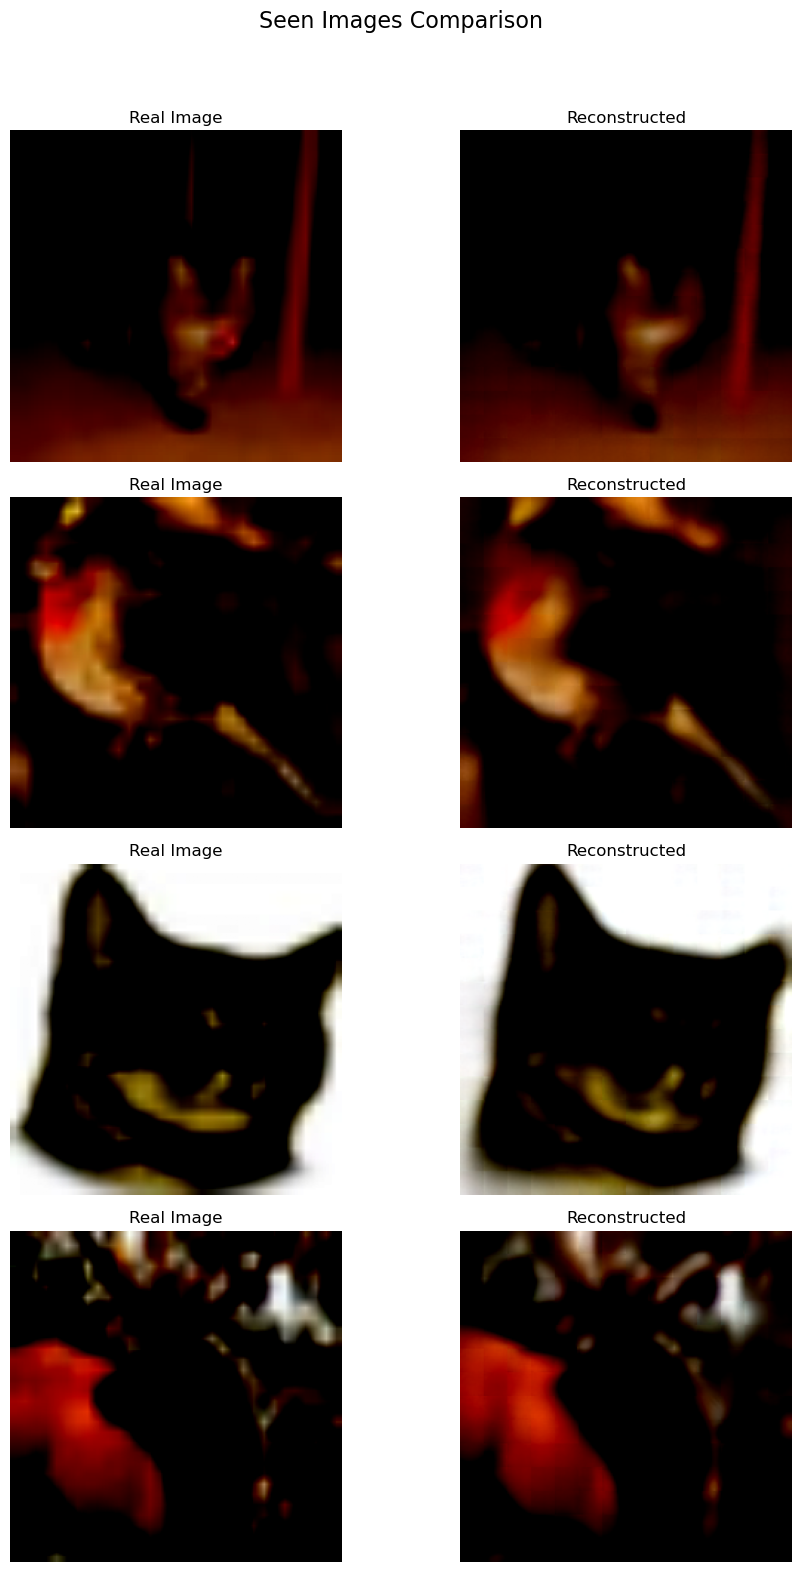

NameError: name 'val_loader' is not defined

In [24]:
import os
import matplotlib.pyplot as plt
from einops import rearrange
import torch

def process_batch(loader, device):
    """
    Grabs one batch from the specified loader, runs the model,
    and returns the original images and full-image reconstructions.
    """
    for batch in loader:
        images = batch[0].to(device)
        with torch.autocast('cuda'):
            out = model(images)
        # The MAE model returns reconstructed patches in the 'logits' attribute.
        reconstructions = out.logits
        # Convert from patch format back to full images.
        # This code assumes patches are 16x16 pixels.
        full_recon = rearrange(
            reconstructions, 
            'b (h w) (p1 p2 c) -> b c (h p1) (w p2)',
            h=images.shape[2] // 16, 
            w=images.shape[3] // 16, 
            p1=16, 
            p2=16, 
            c=3
        )
        # Clamp pixel values to [0, 1] for proper visualization.
        images = images.clamp(0, 1)
        full_recon = full_recon.clamp(0, 1)
        return images, full_recon

def save_and_show_grid(images, recons, folder, prefix, num=5, figsize=(10, 4)):
    """
    Saves images as .jpg files and displays a grid comparing original and reconstructed images.
    
    Parameters:
      images (Tensor): Original images (B x C x H x W)
      recons (Tensor): Reconstructed images (B x C x H x W)
      folder (str): Folder to save the images.
      prefix (str): Filename prefix (e.g. 'seen' or 'unseen').
      num (int): Number of images to display.
      figsize (tuple): Size of the figure.
    """
    os.makedirs(folder, exist_ok=True)
    
    # Determine how many images we can actually display
    n = min(num, images.shape[0])
    
    # Create a grid with two columns: original and reconstructed.
    fig, axs = plt.subplots(n, 2, figsize=(figsize[0], figsize[1] * n))
    for i in range(n):
        # Detach and cast to float32 before converting to numpy
        orig = images[i].detach().permute(1, 2, 0).cpu().float().numpy()
        recon = recons[i].detach().permute(1, 2, 0).cpu().float().numpy()
        
        # Save as JPG files.
        orig_filename = os.path.join(folder, f"{prefix}_original_{i}.jpg")
        recon_filename = os.path.join(folder, f"{prefix}_reconstructed_{i}.jpg")
        plt.imsave(orig_filename, orig)
        plt.imsave(recon_filename, recon)
        
        # Plot them.
        axs[i, 0].imshow(orig)
        axs[i, 0].set_title("Real Image")
        axs[i, 0].axis("off")
        axs[i, 1].imshow(recon)
        axs[i, 1].set_title("Reconstructed")
        axs[i, 1].axis("off")
        
    plt.suptitle(f"{prefix.capitalize()} Images Comparison", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# -------------------- Process and display SEEN images (from train_loader) --------------------
model.eval()
seen_images, seen_recons = process_batch(train_loader, device)
save_and_show_grid(seen_images, seen_recons, folder="seen_images", prefix="seen", num=5)

# -------------------- Process and display UNSEEN images (from val_loader) --------------------
unseen_images, unseen_recons = process_batch(val_loader, device)
save_and_show_grid(unseen_images, unseen_recons, folder="unseen_images", prefix="unseen", num=5)


In [25]:
import os
import matplotlib.pyplot as plt
from einops import rearrange
import torch

def process_batch(loader, device):
    """
    Grabs one batch of images from the provided loader, runs them through the model,
    and returns the original images along with the full-image reconstructions.
    """
    for batch in loader:
        images = batch[0].to(device)
        with torch.autocast('cuda'):
            out = model(images)
        # The MAE model returns reconstructed patches in the 'logits' attribute.
        reconstructions = out.logits
        # Convert patch format back to full images.
        # Adjust dimensions if your patch size differs from 16x16.
        full_recon = rearrange(
            reconstructions, 
            'b (h w) (p1 p2 c) -> b c (h p1) (w p2)',
            h=images.shape[2] // 16, 
            w=images.shape[3] // 16, 
            p1=16, 
            p2=16, 
            c=3
        )
        # Clamp the values to [0, 1] to ensure proper visualization.
        images = images.clamp(0, 1)
        full_recon = full_recon.clamp(0, 1)
        return images, full_recon

def save_and_show_grid(images, recons, folder, prefix, num=5, figsize=(10, 4)):
    """
    Saves images as .jpg files and displays a grid of image comparisons.
    
    For each of the 'num' samples:
      - The left column displays the original image.
      - The right column displays the reconstructed image.
    
    Parameters:
      images (Tensor): Original images (B x C x H x W)
      recons (Tensor): Reconstructed images (B x C x H x W)
      folder (str): Output folder to save .jpg files.
      prefix (str): Filename prefix (e.g., "seen" or "unseen").
      num (int): Number of images to display.
      figsize (tuple): Size of the overall figure.
    """
    os.makedirs(folder, exist_ok=True)
    
    # Ensure we don't go out-of-bounds: use the minimum of num and the available images.
    n = min(num, images.shape[0])
    
    # Create a grid with two columns (original and reconstructed) and n rows.
    fig, axs = plt.subplots(n, 2, figsize=(figsize[0], figsize[1] * n))
    for i in range(n):
        # Detach, convert to float32, rearrange dimensions, and convert to NumPy arrays.
        orig = images[i].detach().permute(1, 2, 0).cpu().float().numpy()
        recon = recons[i].detach().permute(1, 2, 0).cpu().float().numpy()
        
        # Save the individual images as .jpg files.
        orig_filename = os.path.join(folder, f"{prefix}_original_{i}.jpg")
        recon_filename = os.path.join(folder, f"{prefix}_reconstructed_{i}.jpg")
        plt.imsave(orig_filename, orig)
        plt.imsave(recon_filename, recon)
        
        # Plot the images in the grid.
        axs[i, 0].imshow(orig)
        axs[i, 0].set_title("Real Image")
        axs[i, 0].axis("off")
        axs[i, 1].imshow(recon)
        axs[i, 1].set_title("Reconstructed")
        axs[i, 1].axis("off")
        
    plt.suptitle(f"{prefix.capitalize()} Images Comparison", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# -------------------- Displaying SEEN image comparisons (from train_loader) --------------------
model.eval()
seen_images, seen_recons = process_batch(train_loader, device)
save_and_show_grid(seen_images, seen_recons, folder="seen_images", prefix="seen", num=5)

# -------------------- Displaying UNSEEN image comparisons (from val_loader) --------------------
unseen_images, unseen_recons = process_batch(val_loader, device)
save_and_show_grid(unseen_images, unseen_recons, folder="unseen_images", prefix="unseen", num=5)


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 3.81 GiB of which 7.44 MiB is free. Including non-PyTorch memory, this process has 3.79 GiB memory in use. Of the allocated memory 3.65 GiB is allocated by PyTorch, and 33.31 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)